## Función Cálculo error cuadrático medio

In [6]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

## Lectura de Dataset

In [7]:
df = pd.read_csv("../Data/train_sample.csv")

df

,Datetime,MW
0,7/24/18 23:00,3476
1,7/24/18 22:00,3720
2,7/24/18 21:00,3766
3,7/24/18 20:00,3851
4,7/24/18 19:00,3954
...,...,...
57517,1/1/12 5:00,2279
57518,1/1/12 4:00,2313
57519,1/1/12 3:00,2364
57520,1/1/12 2:00,2465


## Busqueda de duplicados

In [8]:
df[df.Datetime.duplicated(keep=False)]

,Datetime,MW
6284,11/5/17 2:00,2064
6285,11/5/17 2:00,1044
15020,11/6/16 2:00,2350
15021,11/6/16 2:00,2198
23924,11/1/15 2:00,2164
23925,11/1/15 2:00,2257
32660,11/2/14 2:00,2518
32661,11/2/14 2:00,2562


In [9]:
#Se encuentran 4 valores duplicados. los borramos y vemos que no están
# ==============================================================================

df.drop_duplicates(subset=['Datetime'],keep="last",inplace=True)

In [10]:
df[df.Datetime.duplicated(keep=False)]

,Datetime,MW


## Conversión de string a Datetime y set como índice

In [11]:
df = df.set_index('Datetime')
df.index=df.index.map(lambda x : datetime.strptime(x,"%m/%d/%y %H:%M"))
df

,MW
Datetime,
2018-07-24 23:00:00,3476
2018-07-24 22:00:00,3720
2018-07-24 21:00:00,3766
2018-07-24 20:00:00,3851
2018-07-24 19:00:00,3954
...,...
2012-01-01 05:00:00,2279
2012-01-01 04:00:00,2313
2012-01-01 03:00:00,2364


## Ajustes varios, busqueda de nulls, verificación de orden, uso de describe para buscar valores muy locos


In [12]:
df.sort_values('Datetime', inplace=True)

In [13]:
df.isnull().sum()

MW    0
dtype: int64

## En base al describe no hay valores obviamente erroneos

In [14]:
df.describe()

,MW
count,57518.000000
mean,3104.043708
std,599.622761
min,907.000000
25%,2687.000000
50%,3012.000000
75%,3447.000000
max,5445.000000


In [15]:
### Densidad Distribución de valores, impresiona adecuada
# ==============================================================================

<AxesSubplot:ylabel='Density'>

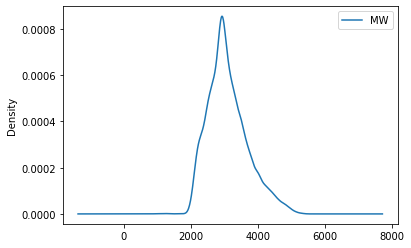

In [16]:
df.plot(kind='kde')

## Me aseguro que no queden Null

In [17]:
x=df[df["MW"].isnull()]
x

,MW
Datetime,


## Gráfico de los valores, no se vé tendencia, si aparece un componente estacional

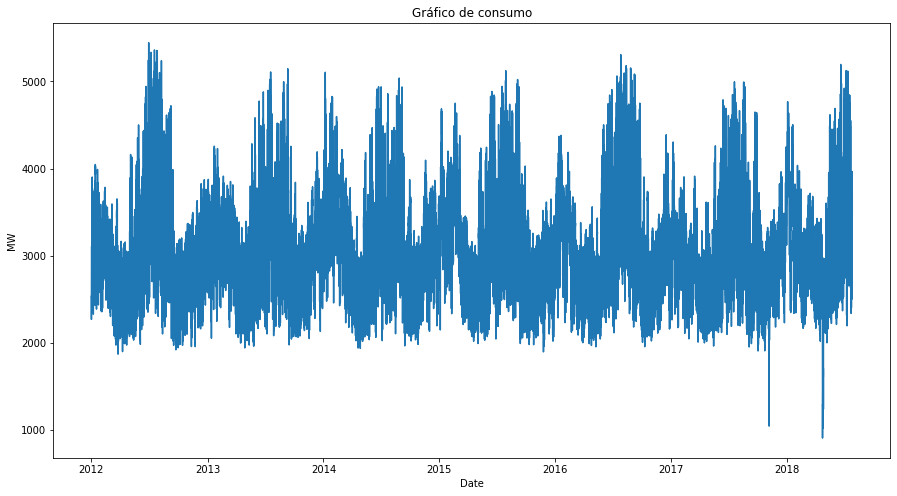

In [86]:
plt.figure(figsize=(15,8))
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("Gráfico de consumo")
plt.plot(df)

## Se confirma que no hay tendencia y Hay un componente estacional

<Figure size 1152x2880 with 0 Axes>

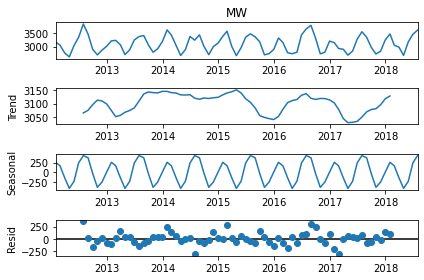

In [19]:
y = df['MW'].resample('1M').mean()


import statsmodels.api as sm
plt.figure(figsize=(16,40))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

## Verifico que el P-vaue es menor que 0,5 con lo cual es estacionaria adicionalmente, no se detecta tendencia en la varianza. Sigue pareciendo estacional.

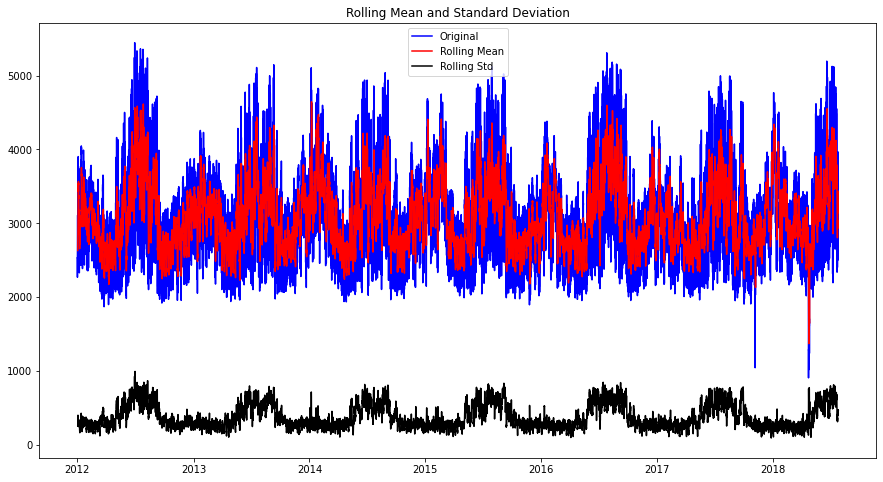

Results of dickey fuller test
Test Statistics               -1.475534e+01
p-value                        2.448854e-27
No. of lags used               5.800000e+01
Number of observations used    5.745900e+04
critical value (1%)           -3.430464e+00
critical value (5%)           -2.861590e+00
critical value (10%)          -2.566797e+00
dtype: float64


In [88]:

test_stationarity(df)

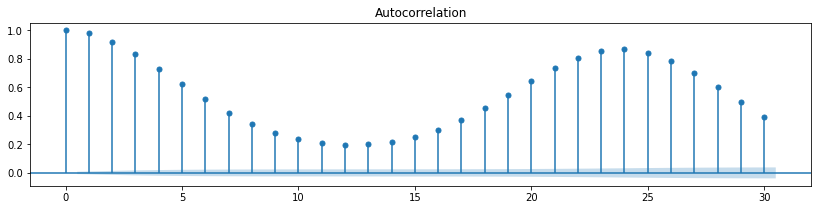

In [21]:
# Autocorrelation plot de la variable, muchos puntos con alta autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(14, 3))
plot_acf(df.MW, ax=ax, lags=30)
plt.show()

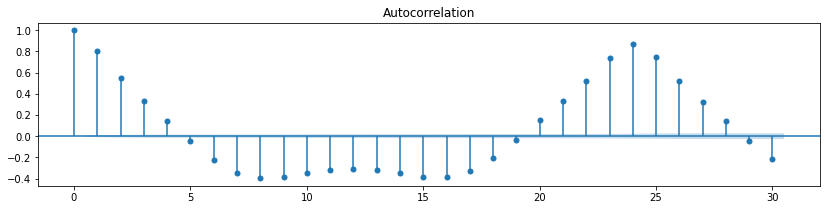

In [82]:
# Autocorrelation plot de la primer diferencía, mejoró 
# ==============================================================================
df_diff=df.diff().dropna()
fig, ax = plt.subplots(figsize=(14, 3))
plot_acf(df_diff.MW, ax=ax, lags=30)
plt.show()

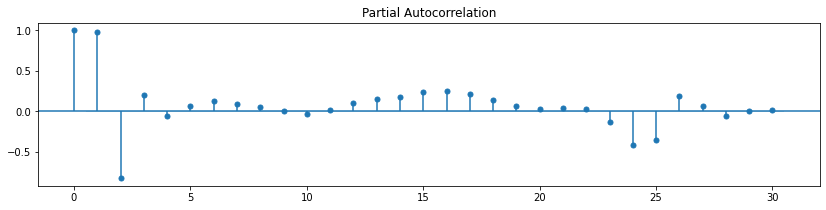

In [23]:
# Autocorrelación Parcial, vemos similar tendencia que en la autocorrelación.
# ==============================================================================

fig, ax = plt.subplots(figsize=(14, 3))
plot_pacf(df.MW, ax=ax, lags=30)
plt.show()

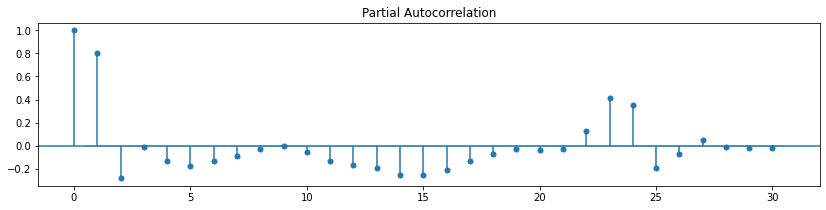

In [24]:
# Partial autocorrelation plot de la diferencia
# ==============================================================================

fig, ax = plt.subplots(figsize=(14, 3))
plot_pacf(df_diff.MW, ax=ax, lags=30)
plt.show()

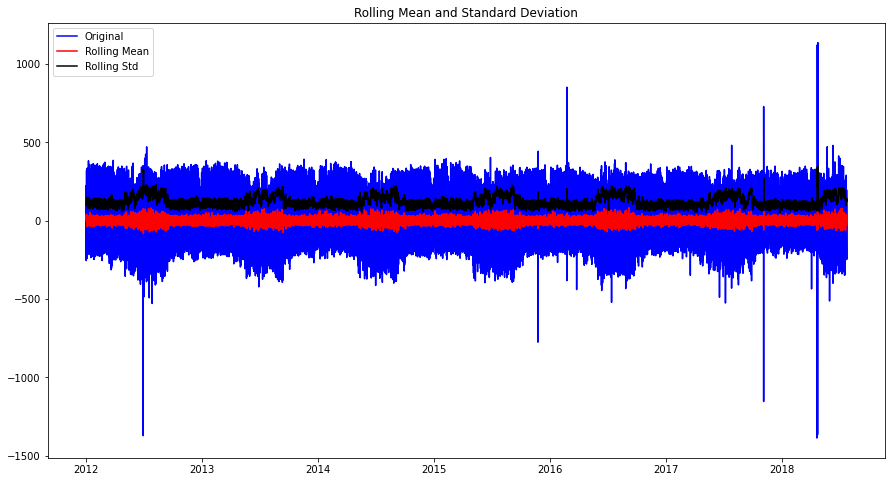

Results of dickey fuller test
Test Statistics                  -37.354321
p-value                            0.000000
No. of lags used                  59.000000
Number of observations used    57457.000000
critical value (1%)               -3.430464
critical value (5%)               -2.861590
critical value (10%)              -2.566797
dtype: float64


In [89]:
#Pruebo Dick folley de la diferencia, da mejor
# ==============================================================================
test_stationarity(df_diff)

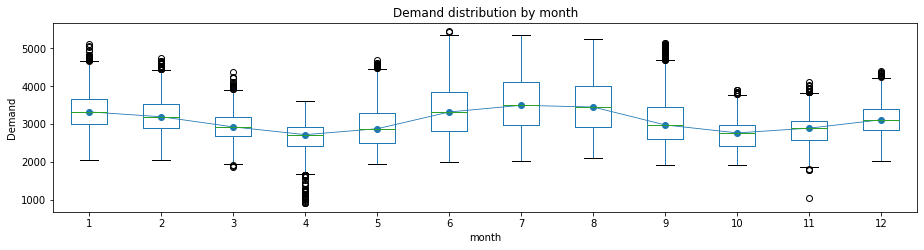

In [26]:
# Boxplot estacionalidad anual
# ==============================================================================
#Impresiona un mayor consumo en julio  y enero, probalemente debido a invierno y verano.

fig, ax = plt.subplots(figsize=(15, 3.5))
df['month'] = df.index.month
df.boxplot(column='MW', by='month', ax=ax,)
df.groupby('month')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('');

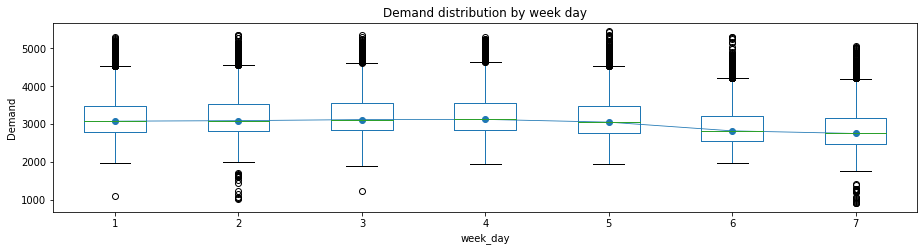

In [27]:
# Boxplot estacionalidad semanal.
# ==============================================================================
#Bastante parejo para todos los días cae, levemente sábado y domingo.

fig, ax = plt.subplots(figsize=(15, 3.5))
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='MW', by='week_day', ax=ax)
df.groupby('week_day')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');

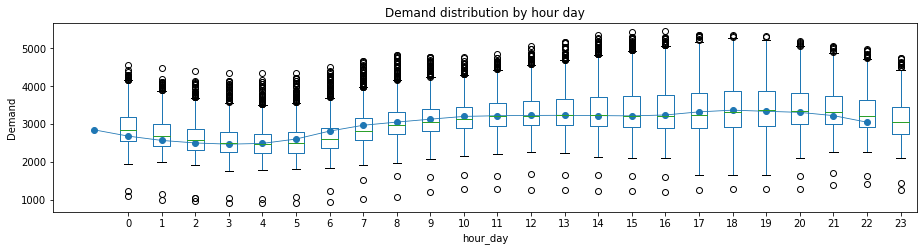

In [28]:
# Boxplot estacionalidad por hora.
# ==============================================================================
#Se percibe un aumento de consumo entre el mediodia y las 20hs.

fig, ax = plt.subplots(figsize=(15, 3.5))
df['hour_day'] = df.index.hour
df.boxplot(column='MW', by='hour_day', ax=ax)
df.groupby('hour_day')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by hour day')
fig.suptitle('');

### Modelo baseline Media 